# Including confounders in association studies

It is known that technical factors influence gene expression. For example, time between donor death and tissue harvesting, is strongly associated to the expression of specific genes. The first principle component of the gene expression data captures this relationship.

We have generated image features from the final layer of a neural network (InceptionetV3) retrained to differentiate between tissue types. Interestingly, certain features are strongly correlated with technical variation, suggesting that this technical variation manifests in the images. The transcripts that are known to be associated with these technical factors, then have a relationship to these image features.

Are these image features associated with variation that is not purely technical? We use linear mixed models (LMMs) to answer this question. The goal is to account for known technical variation in the model, and only report unaccounted associations that are more likely to be biologically interesting.

One result of having technical factors causing so many associations is that it means that the resulting p-values are **highly inflated**. This means that we see far more significant pvalues than we expect to. For example, take the raw associations between the top 100 varying image features and the 100 most highly expressed genes along with the 100 most highly expressed transcripts.

On the RHS, we show a QQ plot, which is a graph comparing the expected number of highly associated genes to the number of strong associations we expect to see by chance.

on the LHS, we see a histogram of the p-values.

We see far more highly associated p-values than we expect.

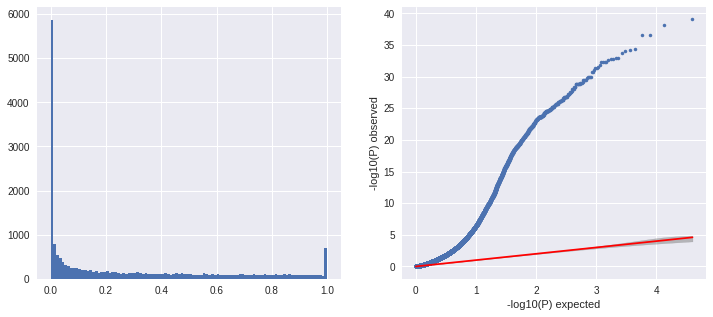

In [1]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
warnings.filterwarnings("ignore")
most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))
pvalues = results['mean_256_pvalues'].flatten()
fig, ax = plt.subplots(1,2,figsize=(12,5))
qqplot(pvalues,alphaLevel=0.05,ax = ax[1])
ax[0].hist(pvalues,bins=100)
plt.show()

We see many more strongly associated -log10 p-values than we expect.

We can quantify the level of inflation by looking at the $\lambda$ statistic. The lambda distribution looks at the distribution of the test statistic before they are converted into p-values. The $\lambda$ value is defined as the median of the test-statistics, which are $\chi^2$, divided by the median of the $\chi^2$ distribution with one degree of freedom, which is 0.456. 

The $\lambda$ statistic is also implemented in Limix, with the following function.

In [2]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

In [3]:
estimate_lambda(pvalues)

5.0707637669115897

We see an extremely high value of $\lambda$ for these p-values. Trustworthy sets of p-values are generally close to 1. We would like to correct for this and achieve fewer globally associated p-values.

In [4]:
simulated_pvalues = np.random.random(200*100)

estimate_lambda(simulated_pvalues)

0.98466814373207667

For pvalues that are artificially simulated, we see that this lambda statistic is very close to 1.

## Linear mixed models

Linear models start simple: they assumed that a trait $Y$ can be explained entirely by a fixed relationship to a set of predictors, along with some residual error.

$$ Y = X \beta + \epsilon $$

Linear mixed models account for known variation in linear models. They do this by quantifying the variation caused by *fixed effects* and *random effects*.

$$\begin{equation} Y = X \beta + Zu + \epsilon \end{equation}$$

The $X\beta$ corresponds to the *fixed effect*, and the $Zu + \epsilon$ corresponds to the *random effect*.

There is good reason to believe this formulating a phenotype into this relationship is useful, especially when we know that there exists distinct groups within our set of predictors.

$u$ here can be thought of as a fixed value, similar to $\beta$. However, it is more commonly described as a random variable.

$$u \sim N(0,D)$$

An important point to notice, is that $u$ has mean $0$. All the fixed effects are captured in the $X\beta$ term. It is therefore important to include any group fixed effects into the $X$ matrix.

To make this clear, let us assume that trait $Y$ is modelled as the sum of a fixed and random effect, as before. Let us in addition assume that the group membership of a specific data point causes a a fixed effect on the mean. 


$$ Y = X\beta + Z\gamma + Zu $$

$\gamma$ is a vector of coefficients which quantifies the fixed effect of being in a specific group. The information that encodes which group a certain data point came from, is given by the design matrix $Z$.

This can be formulated in the following way:


$$ Y = \begin{pmatrix}X & Z\end{pmatrix} \begin{pmatrix}\beta \\ \gamma\end{pmatrix} + Zu$$

i.e. 

$$ Y = X^*\beta^* + Zu$$

For some other $X^*$ and $\beta^*$. This is the same formulation as before, if we remember to include group membership in our set of predictors.


Since $u$ is a random variable, we don't actually estimate it. We estimate the variance covariance matrix $D$.

Finally, we need to estimate the residual term, $\epsilon$.
 
$$\epsilon \sim N(0,R) $$

In our specific case, we want to quantify the variation of our image features outside of known technical factors. As such, we treat these factors as **fixed effects**. Fixed-effects are commonly used to capture the effect of being in a group, whereas random effect capture the effect of repeated trials from a single individual. Right now, we do not have any repeated measures, so we do not include random effects.

LMM are already included in limix - a package developed by the Stegle group at the EBI which implements well known models from statistical genetics. Specifically, it is included as `limix.qtl.qtl_test_lmm`. This function takes in as parameters the snps matrix and phenotype vector, as well as optional parameters specifying the covariance structure of the data that we want to include as fixed effects. In our data, we have a matrix of gene expression values, but this can be inputted into limix without a problem. 

## Plan

We want to choose the best way to account for this technical variation. How do we do this? First we choose two methods:

- Include our 4 known technical factors as random / fixed effects.
- Include the first 5 PCs as random / fixed effects.

How do we decide which is the best method? We'll do this by measuring the inflation parameter $\lambda$. This parameter is defined as the median of of the distribution of the raw test statistics, and the median of a $\chi^2$ distribution with 1 degree of freedom. The closer this number is to 1, the more technical variation has been removed from the model.

## Specifying the technical covariates

First, we load the precomputed features.

In [5]:
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = expression[:,most_varying_feature_idx]

To specify the technical covariates, we mine the phenotype data.

These acronyms, SMTSISCH, SMRIN, SMEXNCRT, and SMNTRNRT mean:
- Time between tissue death and harvesting
- RIN number (RNA degradation)
- Exon mapping number
- Intro mapping number

Respectively. They can directly be added into lmm as covariates.

In [6]:
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]

SMTSISCH = np.log(np.array(lung_df['SMTSISCH']).astype(np.float32))
SMTSISCH = SMTSISCH[phenotype_idx]
SMRIN = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMRIN']) ])
SMRIN = SMRIN[phenotype_idx]
SMEXNCRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMEXNCRT']) ])
SMEXNCRT = SMEXNCRT[phenotype_idx]
SMNTRNRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMNTRNRT']) ])
SMNTRNRT = SMNTRNRT[phenotype_idx]
raw_technical_covariates = np.array([SMTSISCH,SMRIN,SMEXNCRT,SMNTRNRT]).T
technical_idx = np.sum(raw_technical_covariates > 0, axis=1) == 4

We take the top 100 most variable image features, along with the top 100 transcripts with highest mean expression and the 100 transcript with the highest variance

In [7]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)


We then take the indexes for which we have technical covariate data. Technical factors for which there is missing data are given the value 0 - however this is treated as a 0 value in the analysis, and causes a problem. 231 out of 274 of the samples have all of the technical factor information.

In [8]:
filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


We want shuffled copies of the phenotype, to investigate what the null p-values look like.

In [9]:
shuffled_idx = list(range(filt_tech_features.shape[0]))
np.random.shuffle(shuffled_idx)
shuffled_filt_tech_features1 = filt_tech_features[shuffled_idx,:]
np.random.shuffle(shuffled_idx)
shuffled_filt_tech_features2 = filt_tech_features[shuffled_idx,:]
np.random.shuffle(shuffled_idx)
shuffled_filt_tech_features3 = filt_tech_features[shuffled_idx,:]
np.random.shuffle(shuffled_idx)
shuffled_filt_tech_features4 = filt_tech_features[shuffled_idx,:]
np.random.shuffle(shuffled_idx)
shuffled_filt_tech_features5 = filt_tech_features[shuffled_idx,:]


In [10]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float))

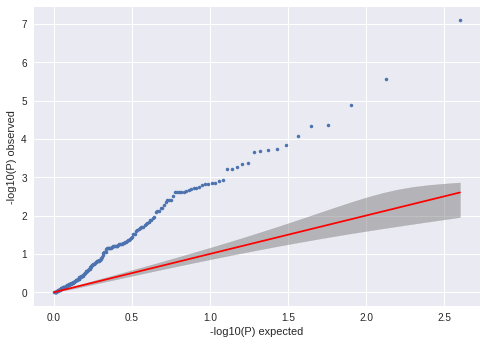

In [11]:
from limix.plot import qqplot
lim_pvalues = res.getPv().flatten()
qqplot(lim_pvalues)

Even using lim, we see that our p-values are less inflated. Indeed, we can look at our $\lambda$ statistic.

In [12]:
estimate_lambda(lim_pvalues)

4.9437715861936482

This $\lambda$ statistics is still extremely high. Most papers report a $\lambda$ statistic of closer to 1, so we still have some work to do.

## Including technical variation in the limix model.

### Random effects

Here I include the random effects in the limix `cov` parameter.

4.7497470125809143

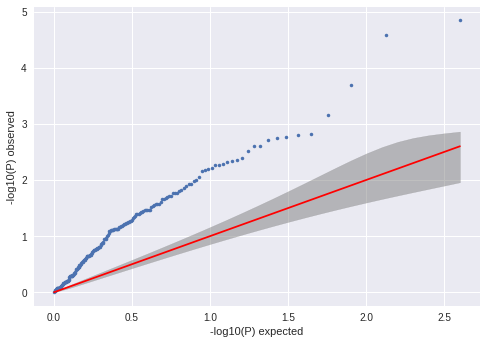

In [13]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=raw_technical_covariates)
pvalues = res.getPv()
from limix.plot import qqplot
lim_pvalues = res.getPv().flatten()
qqplot(lim_pvalues)
estimate_lambda(lim_pvalues)

Here we see a reduction in the $\lambda$ value, but not by much. It is also much high than 1.

## Including top 5 PCs as covariates

If we include the technical covariates in the model, we still see a high level of inflation. What about if we include the first 5 PCs?

2.52788983311


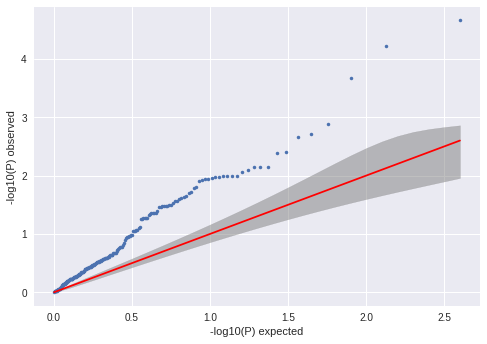

In [14]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 5
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This seems to account for some of the variation that exists.

What about for the first 15 PCs?

1.60345256528


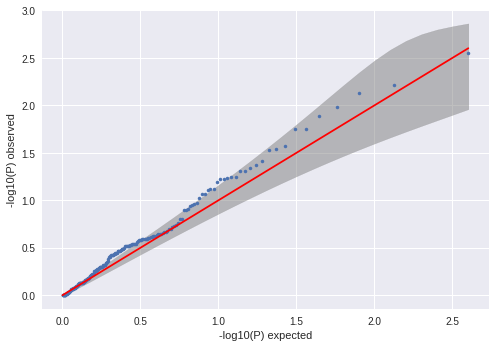

In [15]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 15
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This now seems to be removing all the noticable inflation including the signal.

How does the lambda value vary as a function of number of PCs we include?

In [16]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

lambdas = []
for k in range(1,20):
    feature = 0
    pca = PCA(n_components=k)
    pca_transform = pca.fit_transform(filt_expression)
    pca_transform.shape
    test_cov = np.ones(shape=(274,k + 1))
    
    test_cov[:,1:] = pca_transform

    single_feature = filt_features[:,feature].copy()
    res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
    pvalues = res.getPv()

    lim_pvalues = res.getPv().flatten()
    lamb = estimate_lambda(lim_pvalues)
    lambdas.append(lamb)

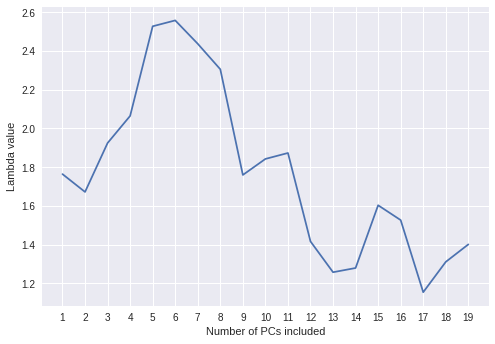

In [17]:
plt.plot(range(1,20),lambdas)
plt.xticks(range(1,20),range(1,20))
plt.xlabel("Number of PCs included")
plt.ylabel("Lambda value")
plt.show()

Interestingly, there seems to be a maximum at 5 PCs.

What about using the first two PCs?

1.67222500006


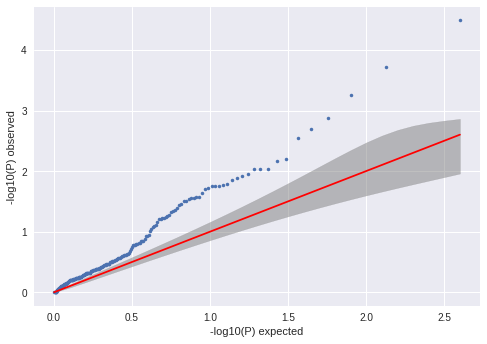

In [21]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

k = 2
feature = 0
pca = PCA(n_components=k)
pca_transform = pca.fit_transform(filt_expression)
pca_transform.shape
test_cov = np.ones(shape=(274,k + 1))

test_cov[:,1:] = pca_transform

single_feature = filt_features[:,feature].copy()
res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
pvalues = res.getPv()

lim_pvalues = res.getPv().flatten()
lamb = estimate_lambda(lim_pvalues)
print (lamb)
qqplot(lim_pvalues)


This is a low value of $\lambda$, given the values of lambda that we have seen. But there is still are high level of overall inflation.

## Including as fixed effects

It might be better to just include these factors as fixed effects, and to build the models one SNP at a time.

Before, we are have been asking whether a specific transcript $T$ is significantly associated to a phenotype $Y$ across $n$ samples. Now let's assume that we have $t$ covariates. If we model:

$$ Y = X\beta $$

where $X$ is a matrix of size $n \times (t + 1) $, containing the $t$ technical covariates, and with the final column as the transcript expression values. $\beta$ is a $1 \times (t + 1)$ vector. The first $t$ entries of $\beta$ would be the effect sizes on the phenotype from each of the technical covariates. The final element of $\beta$ would be the effect size of that specific SNP on the phenotype, having already taken into account the technical variation.

$\beta$ can be estimated with linear regression.



In [19]:
filt_raw_technical_covariates = raw_technical_covariates[technical_idx,:]

First, we need to extend sklearn's Linear Regression to return the p-values estimates. This is taken from [here](https://gist.github.com/brentp/5355925).

In [22]:
from sklearn import linear_model
from scipy import stats
import numpy as np
import pdb


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [126]:
def calculate_association(t,y,shuffle=False):
    X = np.ones(shape=(filt_raw_technical_covariates.shape[0],filt_raw_technical_covariates.shape[1] + 2))
    X[:,1:5] = filt_raw_technical_covariates
    X[:,-1] = filt_tech_expression[:,t]
    lr = LinearRegression()
    if shuffle:
        res = lr.fit(X, eval('shuffled_filt_tech_features{}[:,y]'.format(shuffle)))
    else:
        res = lr.fit(X, filt_tech_features[:,y])
    return res


We calculate the pvalue for each of these transcripts, taking into account the known technical variation.

In [25]:

try:
    [shuffled_results1, shuffled_results2, shuffled_results3, shuffled_results4, shuffled_results5, results] = pickle.load(open('results1.py','rb'))
except:
    results = {}
    shuffled_results1 = {}
    shuffled_results2 = {}
    shuffled_results3 = {}
    shuffled_results4 = {}
    shuffled_results5 = {}
    for t in range(200):
        if t % 50 == 0:
            print (t)
        for y in range(100):
            results['{}-{}'.format(t,y)] = calculate_association(t,y)
            shuffled_results1['{}-{}'.format(t,y)] = calculate_association(t,y,shuffle=1)
            shuffled_results2['{}-{}'.format(t,y)] = calculate_association(t,y,shuffle=2)
            shuffled_results3['{}-{}'.format(t,y)] = calculate_association(t,y,shuffle=3)
            shuffled_results4['{}-{}'.format(t,y)] = calculate_association(t,y,shuffle=4)
            shuffled_results5['{}-{}'.format(t,y)] = calculate_association(t,y,shuffle=5)
            
    pickle.dump([shuffled_results1, shuffled_results2, shuffled_results3, shuffled_results4, shuffled_results5, results],open('results1.py','wb'))


pvalues = []
betas = []
shuffled_pvalues1 = []
shuffled_pvalues2 = []
shuffled_pvalues3 = []
shuffled_pvalues4 = []
shuffled_pvalues5 = []

shuffled_betas = []
for t in range(200):
    if t % 50 == 0:
        print (t)
    for y in range(100):
        
        pvalues.append(results['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues1.append(shuffled_results1['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues2.append(shuffled_results2['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues3.append(shuffled_results3['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues4.append(shuffled_results4['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues5.append(shuffled_results5['{}-{}'.format(t,y)].p[-1])
        
        
        betas.append(results['{}-{}'.format(t,y)].coef_[-1])
        shuffled_betas.append(shuffled_results1['{}-{}'.format(t,y)].coef_[-1])


0
50
100
150


The betas seem to be normally distributed.

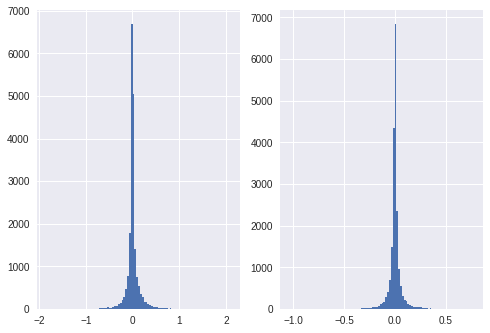

In [26]:
f, a = plt.subplots(1,2)
a[0].hist(betas,bins=100)
a[1].hist(shuffled_betas,bins=100)
fig.show()

But the pvalues still seem to be inflated

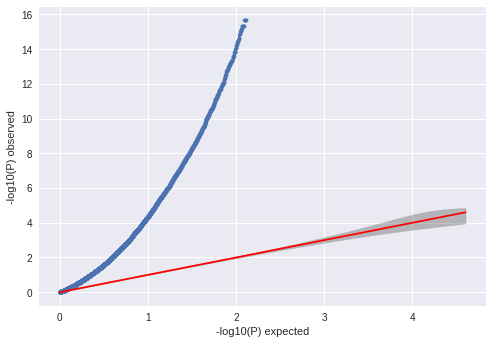

In [27]:
qqplot(np.array(pvalues))

However, on shuffling we see exactly the number of pvalues we expect. We perform 5 shuffles.

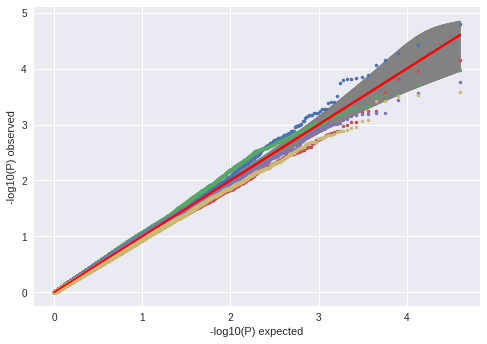

In [28]:
qqplot(np.array(shuffled_pvalues1))
qqplot(np.array(shuffled_pvalues2))
qqplot(np.array(shuffled_pvalues3))
qqplot(np.array(shuffled_pvalues4))
qqplot(np.array(shuffled_pvalues5))

Are there very small p-values with large large effect sizes?

Yes there are, and there seems to be factors which are independent of the technical effects I have included.

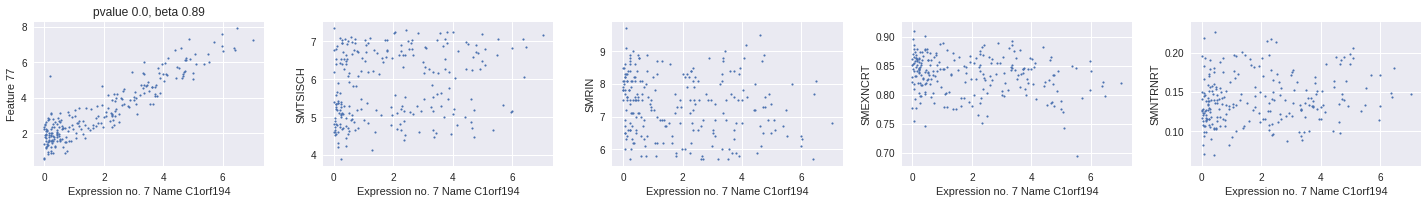

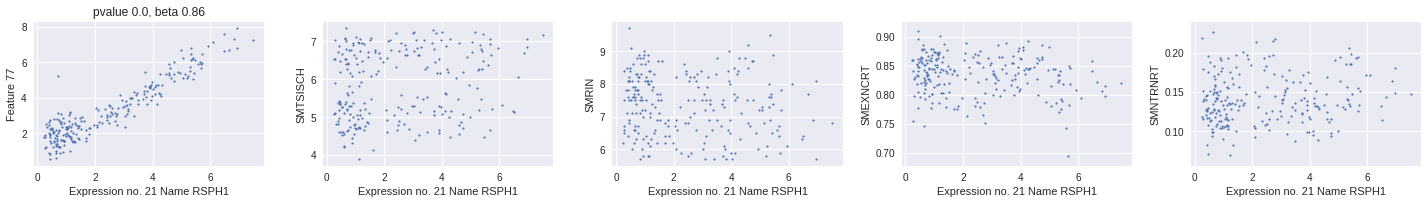

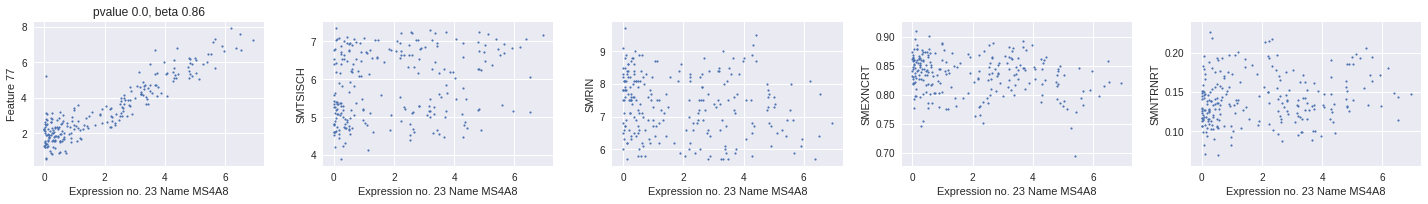

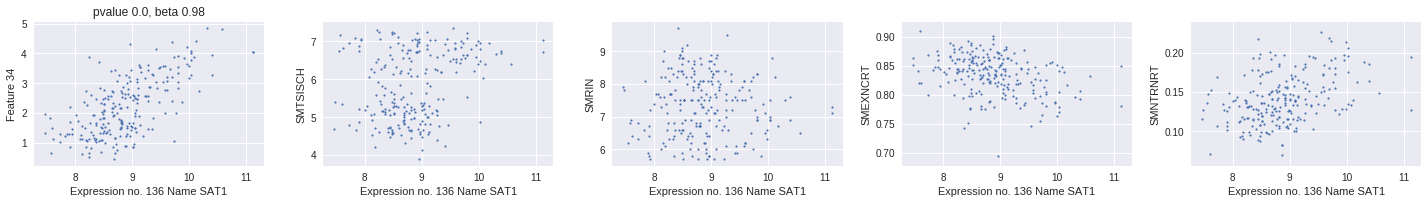

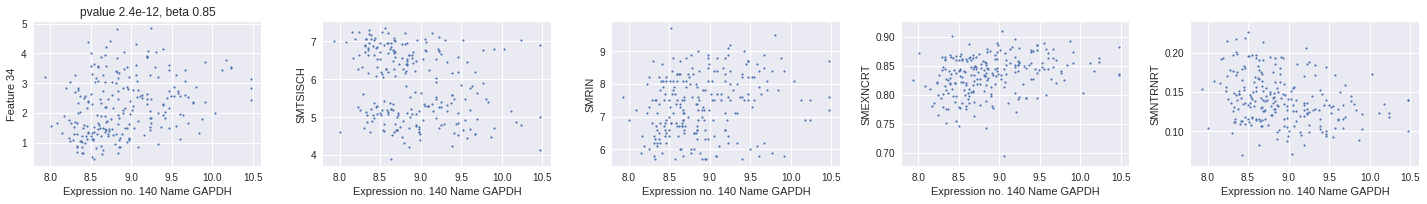

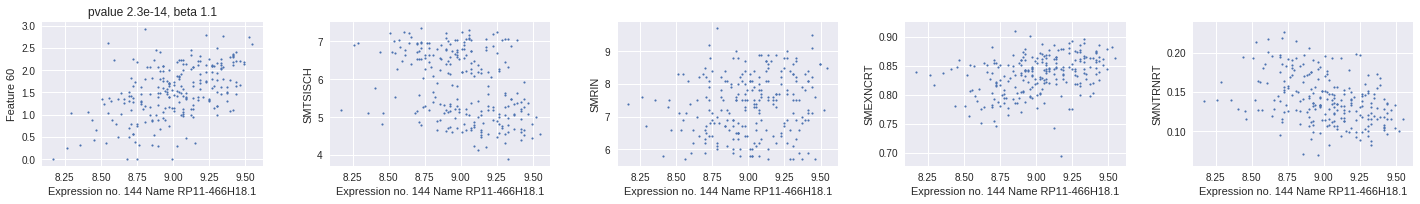

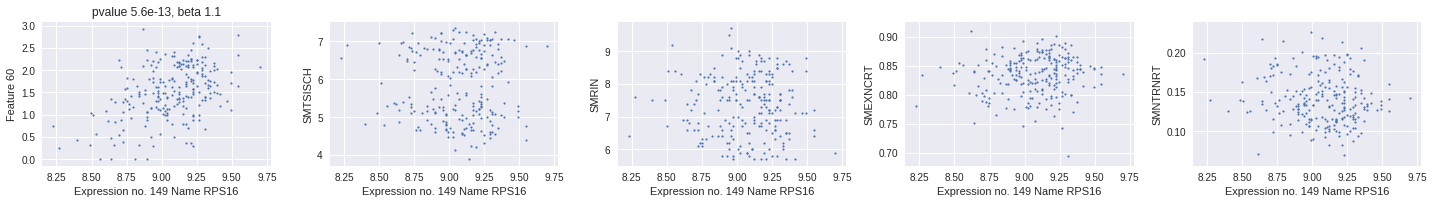

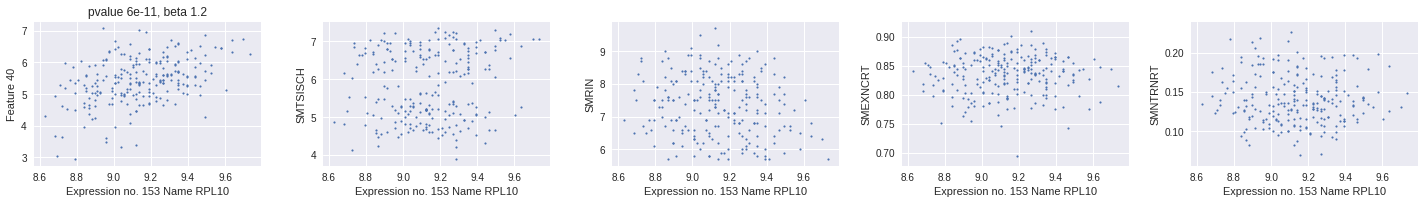

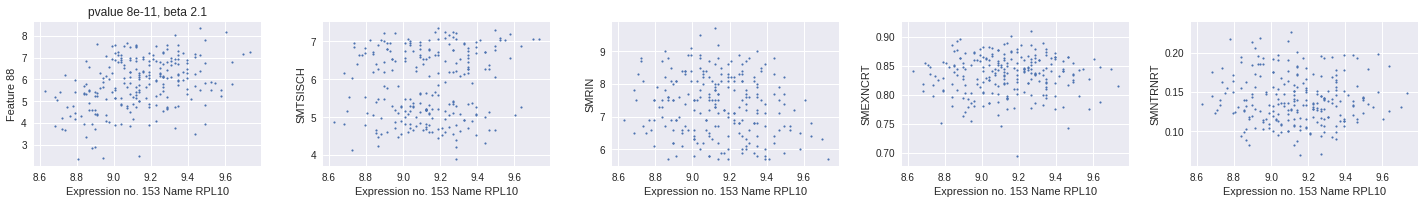

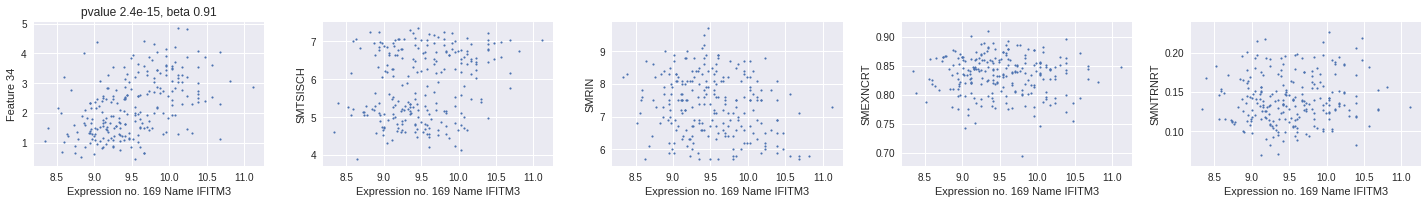

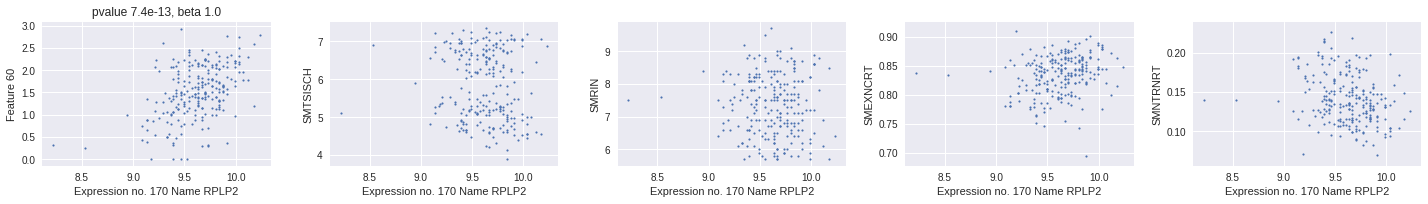

In [29]:
from pyensembl import EnsemblRelease

import pdb
data = EnsemblRelease(77)
expression_IDs[most_expressed_transcript_idx][t]
def get_gene_name(transcript):
    transcript_id = transcript.decode('utf-8').split('.')[0]
    return data.gene_name_of_gene_id(transcript_id)
    
def display_scatter(t,y):
    fig, ax = plt.subplots(1,5,figsize=(20,3))
    pvalue = results['{}-{}'.format(t,y)].p[-1]
    beta = results['{}-{}'.format(t,y)].coef_[-1]
    
    ax[0].scatter(filt_tech_expression[:,t], filt_tech_features[:,y],s=3)
    ax[0].set_title('pvalue {:.2}, beta {:.2}'.format(pvalue,beta))
    ax[0].set_xlabel("Expression no. {} Name {}".format(t, get_gene_name(expression_IDs[most_expressed_transcript_idx][t])))
    ax[0].set_ylabel("Feature {}".format(y))
    
    labels = ['SMTSISCH','SMRIN','SMEXNCRT','SMNTRNRT']
    for k in range(4):    
        ax[k+1].scatter(filt_tech_expression[:,t], filt_raw_technical_covariates[:,k],s=3)
        ax[k+1].set_xlabel("Expression no. {} Name {}".format(t, get_gene_name(expression_IDs[most_expressed_transcript_idx][t])))
        ax[k+1].set_ylabel(labels[k])
        
    fig.tight_layout()
    
for t in range(200):
    for y in range(100):
        pvalue = results['{}-{}'.format(t,y)].p[-1]
        beta = results['{}-{}'.format(t,y)].coef_[-1]
        if pvalue < 1e-10 and beta > 0.85:
            try:
                display_scatter(t,y)
            except ValueError:
                continue
            

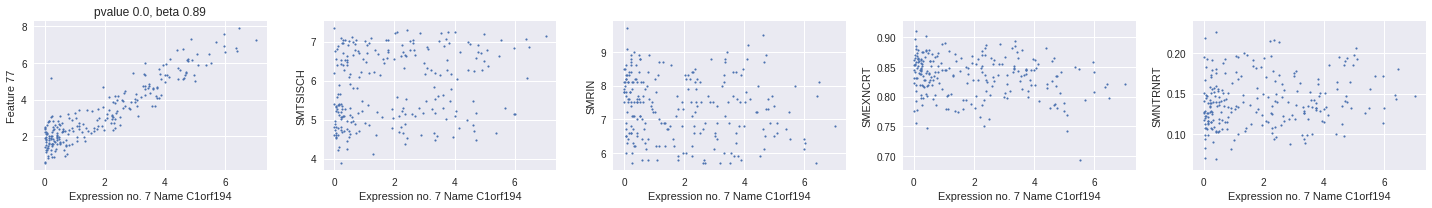

In [104]:
display_scatter(7,77)

## Including both raw technical factors and top 5 PCs as fixed effects

We have seem that there is definitely some variation outside of the four technical factors that we have identified. But this does not preclude unknown technical variation having an impact. We have already seen that the first few PCs capture a lot of technical variation, so we include the first 5 PCs as fixed effects. This will then test whether there is individual variation of specific transcripts to features, outside of these global effects.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_filt_tech_expression = pca.fit_transform(filt_tech_expression)

def calculate_association_tech_and_PCs(t,y,shuffle=False):    
    X = np.ones(shape=(filt_raw_technical_covariates.shape[0],filt_raw_technical_covariates.shape[1] + pca_filt_tech_expression.shape[1] + 2))
    X[:,1:5] = filt_raw_technical_covariates
    X[:,5:10] = pca_filt_tech_expression
    X[:,-1] = filt_tech_expression[:,t]
    lr = LinearRegression()
    if shuffle:
        res = lr.fit(X, eval('shuffled_filt_tech_features{}[:,y]'.format(shuffle)))
    else:
        res = lr.fit(X, filt_tech_features[:,y])
    return res

Compute the associations between our selection of image features and transcripts.

In [31]:

try:
    [shuffled_results1, shuffled_results2, shuffled_results3, shuffled_results4, shuffled_results5, results] = pickle.load(open('results2.py','rb'))
except:
    results = {}
    shuffled_results1 = {}
    shuffled_results2 = {}
    shuffled_results3 = {}
    shuffled_results4 = {}
    shuffled_results5 = {}
    for t in range(200):
        if t % 50 == 0:
            print (t)
        for y in range(100):
            results['{}-{}'.format(t,y)] = calculate_association_tech_and_PCs(t,y)
            shuffled_results1['{}-{}'.format(t,y)] = calculate_association_tech_and_PCs(t,y,shuffle=1)
            shuffled_results2['{}-{}'.format(t,y)] = calculate_association_tech_and_PCs(t,y,shuffle=2)
            shuffled_results3['{}-{}'.format(t,y)] = calculate_association_tech_and_PCs(t,y,shuffle=3)
            shuffled_results4['{}-{}'.format(t,y)] = calculate_association_tech_and_PCs(t,y,shuffle=4)
            shuffled_results5['{}-{}'.format(t,y)] = calculate_association_tech_and_PCs(t,y,shuffle=5)            
            
    pickle.dump([shuffled_results1, shuffled_results2, shuffled_results3, shuffled_results4, shuffled_results5, results],open('results2.py','wb'))
    

        
pvalues = []
betas = []
shuffled_pvalues1 = []
shuffled_pvalues2 = []
shuffled_pvalues3 = []
shuffled_pvalues4 = []
shuffled_pvalues5 = []

shuffled_betas = []
for t in range(200):
    if t % 50 == 0:
        print (t)
    for y in range(100):
        
        pvalues.append(results['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues1.append(shuffled_results1['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues2.append(shuffled_results2['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues3.append(shuffled_results3['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues4.append(shuffled_results4['{}-{}'.format(t,y)].p[-1])
        shuffled_pvalues5.append(shuffled_results5['{}-{}'.format(t,y)].p[-1])
        
        
        betas.append(results['{}-{}'.format(t,y)].coef_[-1])
        shuffled_betas.append(shuffled_results1['{}-{}'.format(t,y)].coef_[-1])

0
50
100
150
0
50
100
150


Display the real betas values and the beta values of one shuffle. Both seem to be normally distributed.

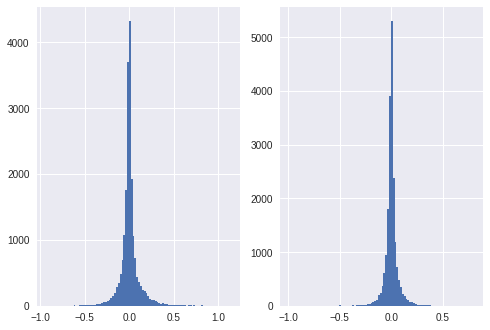

In [32]:
f, a = plt.subplots(1,2)
a[0].hist(betas,bins=100)
a[1].hist(shuffled_betas,bins=100)
fig.show()

Display the qq-plot of the real p-values

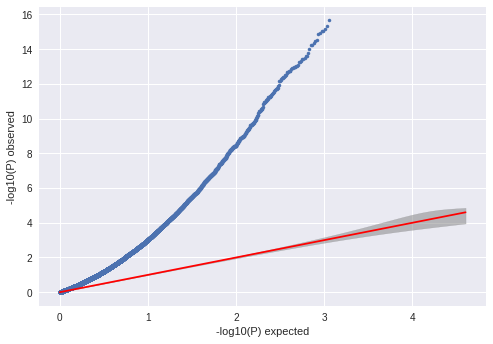

In [33]:
qqplot(np.array(pvalues))

Display the qq plots from 5 shuffles of the data.

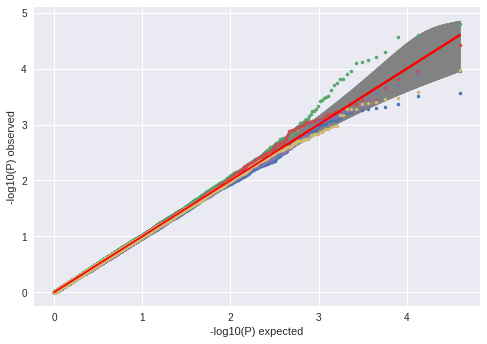

In [34]:
qqplot(np.array(shuffled_pvalues1))
qqplot(np.array(shuffled_pvalues2))
qqplot(np.array(shuffled_pvalues3))
qqplot(np.array(shuffled_pvalues4))
qqplot(np.array(shuffled_pvalues5))

Define the function to produce scatter plots of a particular image feature $f$ and a transcript $t$. Also display the scatterplot of this particlular transcript $t$ against the 4 technical factors and also the first 5 PCs

In [35]:
from pyensembl import EnsemblRelease

import pdb
data = EnsemblRelease(77)
def get_gene_name(transcript):
    transcript_id = transcript.decode('utf-8').split('.')[0]
    return data.gene_name_of_gene_id(transcript_id)
    
def display_scatter(t,y):
    fig, ax = plt.subplots(1,10,figsize=(20,3))
    pvalue = results['{}-{}'.format(t,y)].p[-1]
    beta = results['{}-{}'.format(t,y)].coef_[-1]
    
    ax[0].scatter(filt_tech_expression[:,t], filt_tech_features[:,y],s=3)
    R = pearsonr(filt_tech_expression[:,t], filt_tech_features[:,y])[0]
    ax[0].set_title('pvalue {:.2}, beta {:.2}, R {:.2}'.format(pvalue,beta,R),size=10)
    ax[0].set_xlabel(get_gene_name(expression_IDs[most_expressed_transcript_idx][t]))
    ax[0].set_ylabel("Feature {}".format(y))
    
    tech_labels = ['SMTSISCH','SMRIN','SMEXNCRT','SMNTRNRT']
    for k in range(4):
        ax[k+1].scatter(filt_tech_expression[:,t], filt_raw_technical_covariates[:,k],s=3)
        R = pearsonr(filt_tech_expression[:,t], filt_raw_technical_covariates[:,k])[0]
        ax[k+1].set_title("R {:.2}".format(R))
        ax[k+1].set_xlabel(get_gene_name(expression_IDs[most_expressed_transcript_idx][t]))
        ax[k+1].set_ylabel(tech_labels[k])
        
    pca_labels = ['PC1','PC2','PC3','PC4','PC5']
    for m in range(5):    
        ax[m+5].scatter(filt_tech_expression[:,t], pca_filt_tech_expression[:,m],s=3)
        R = pearsonr(filt_tech_expression[:,t], pca_filt_tech_expression[:,m])[0]
        ax[m+5].set_title("R {:.2}".format(R))
        ax[m+5].set_xlabel(get_gene_name(expression_IDs[most_expressed_transcript_idx][t]))
        ax[m+5].set_ylabel(pca_labels[m])

        
    fig.tight_layout()
    


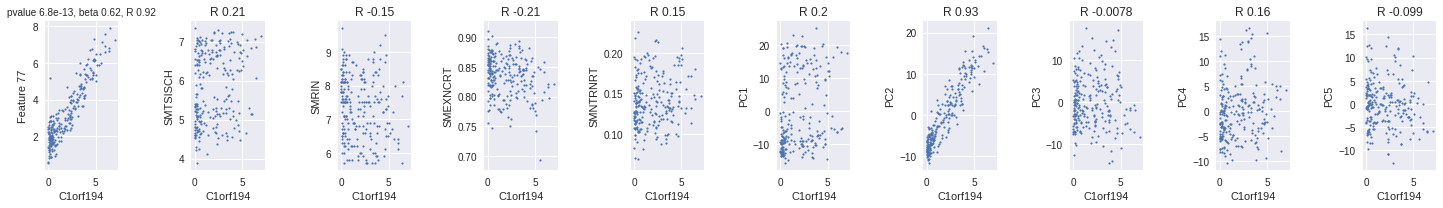

In [120]:
display_scatter(7,77)

6.84563516984e-13 0.623843736986
3.48610029732e-14 0.739959211601
1.81632486829e-13 0.697183675869
0.0 0.723907717121
2.51150211739e-11 0.746554387414
5.9106053385e-12 0.607977732972
2.84354761959e-11 0.606965657279
2.48689957516e-14 0.658498049965
5.95206106624e-11 0.628808587479
3.73159281253e-11 0.697876225576
4.12780920556e-13 0.620690169086
2.09194883638e-11 0.806876915805
2.41340281093e-12 0.607692945459
2.88657986403e-15 1.12810348384
0.0 0.880847188239
5.49471579347e-12 1.05292301136
2.3669954885e-13 0.822446212859
7.81597009336e-14 0.605403482762
5.99520433298e-15 1.07965997209


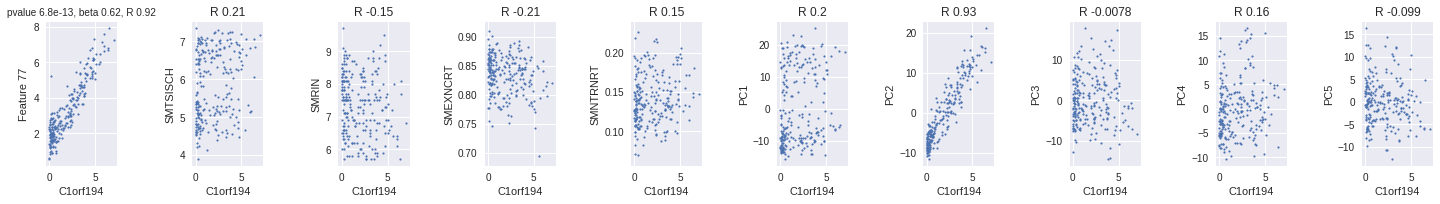

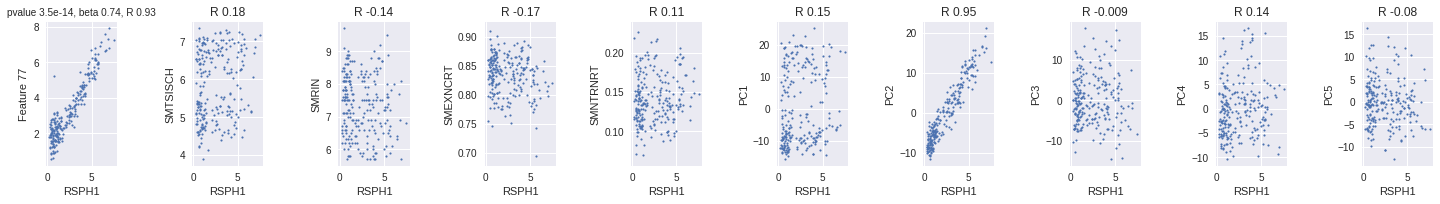

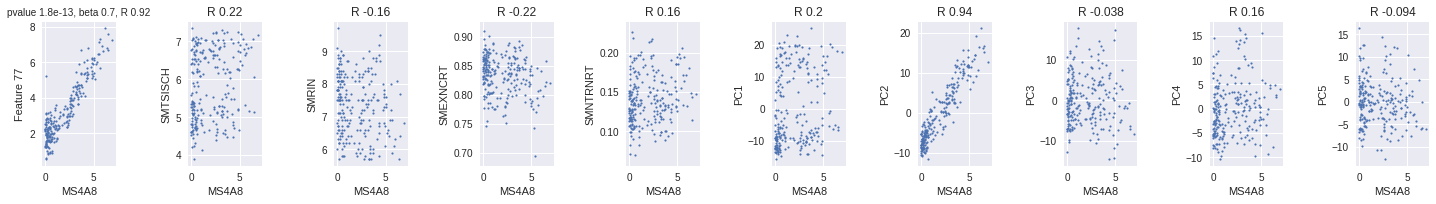

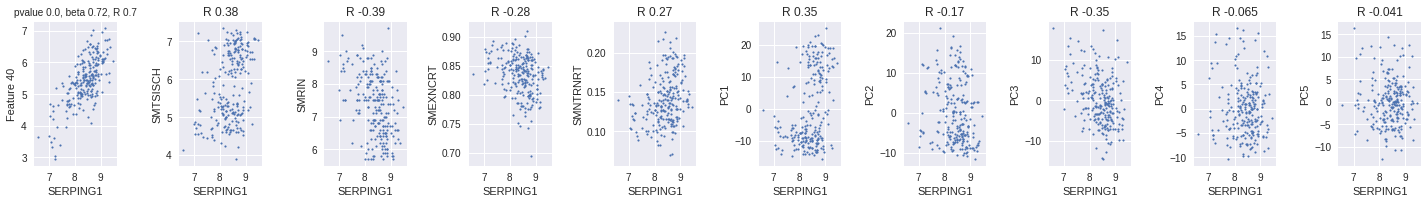

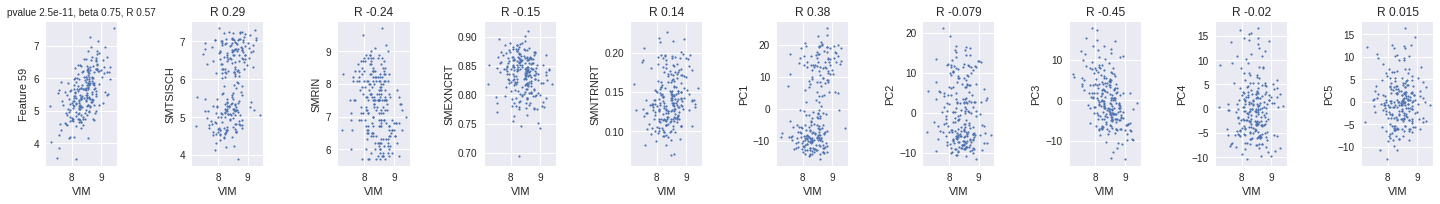

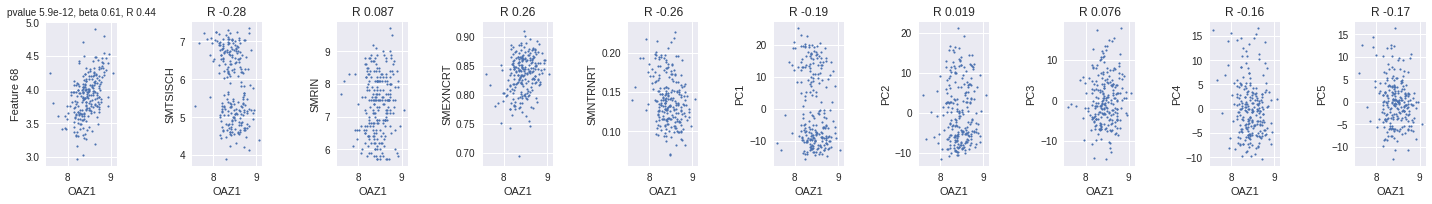

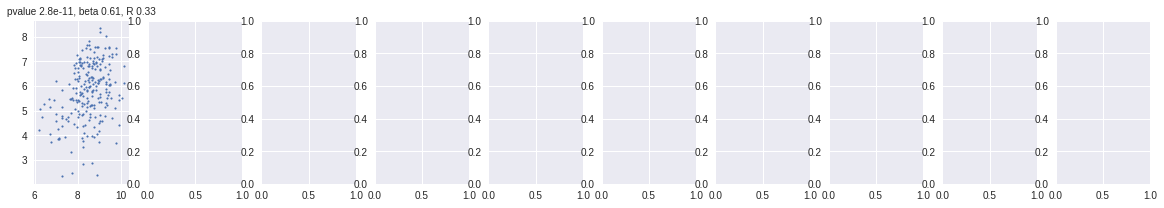

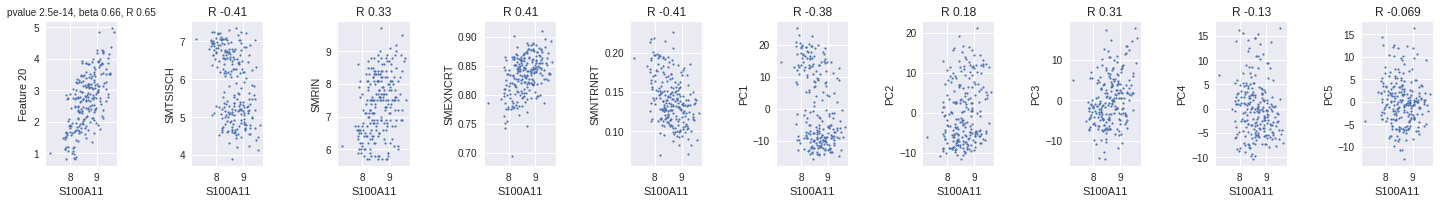

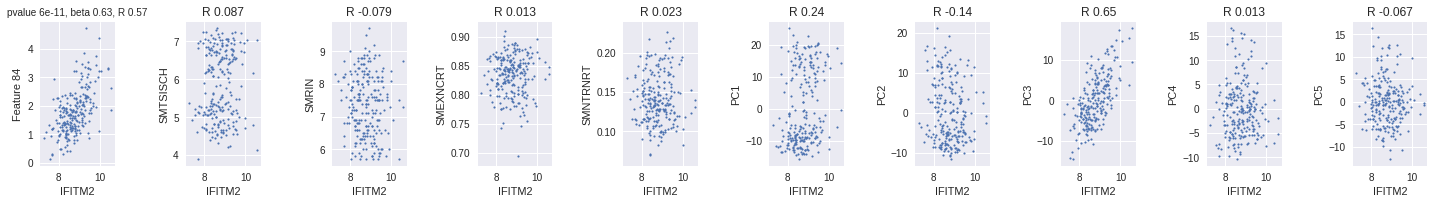

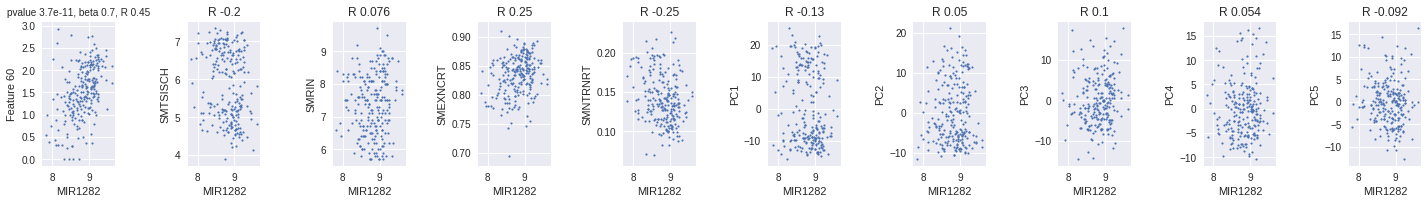

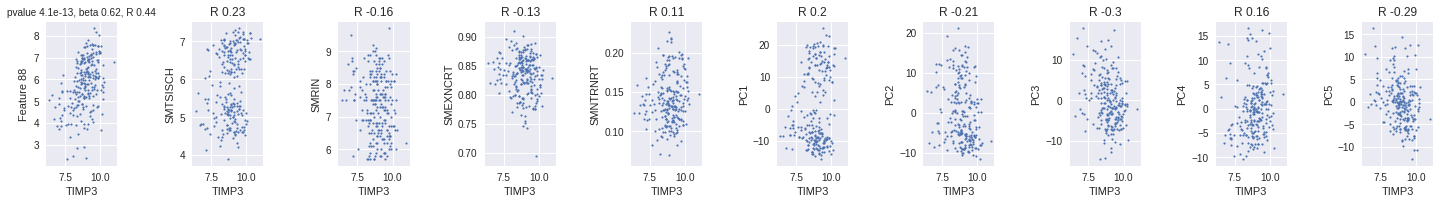

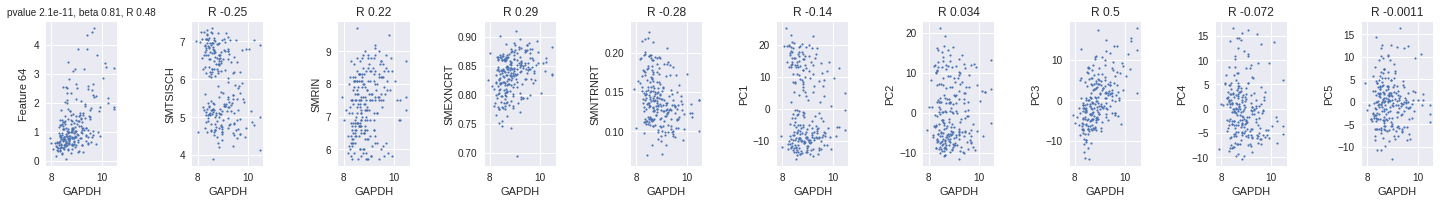

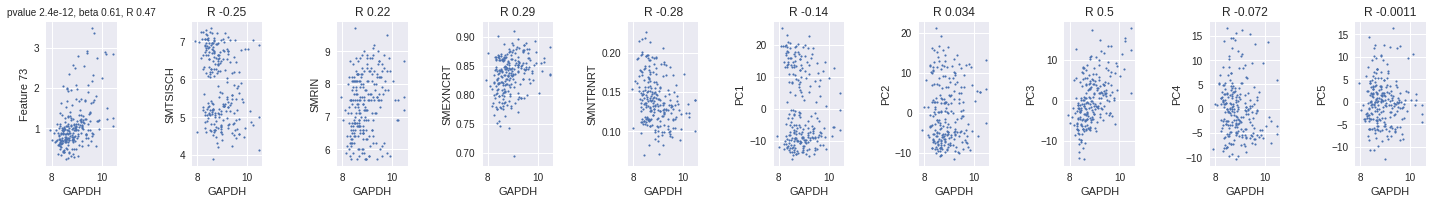

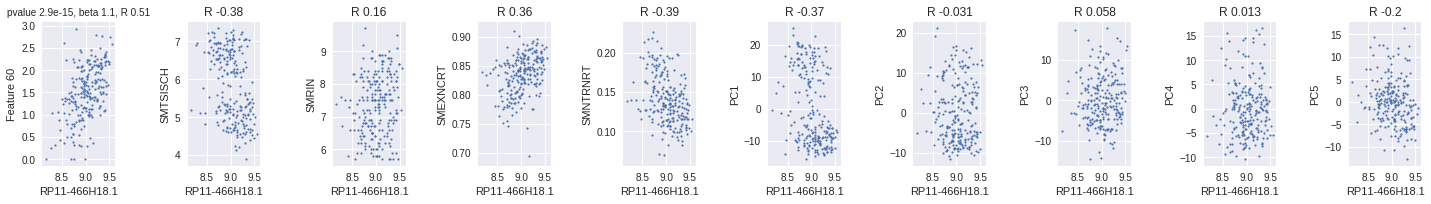

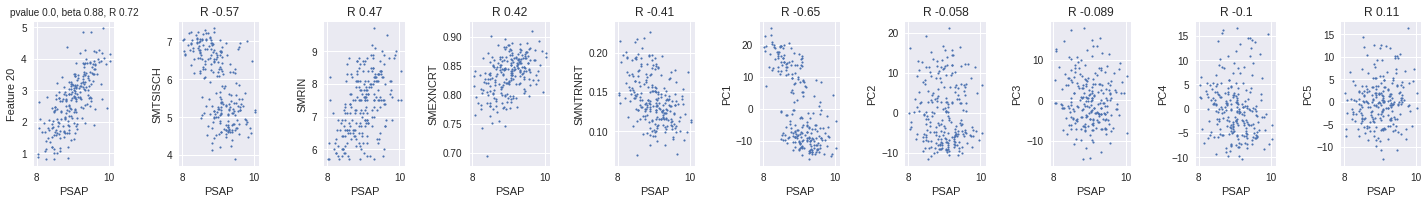

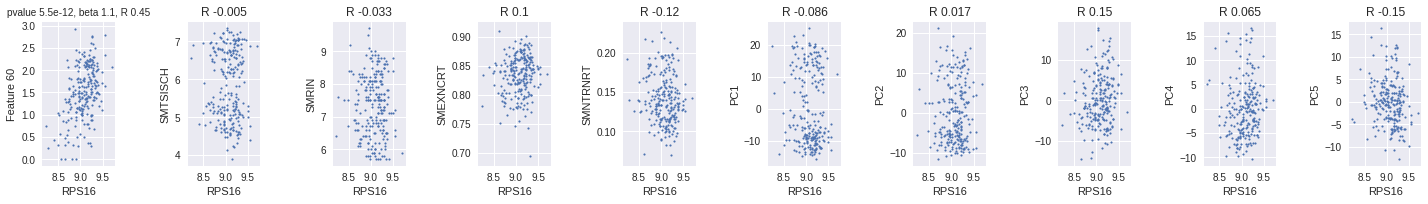

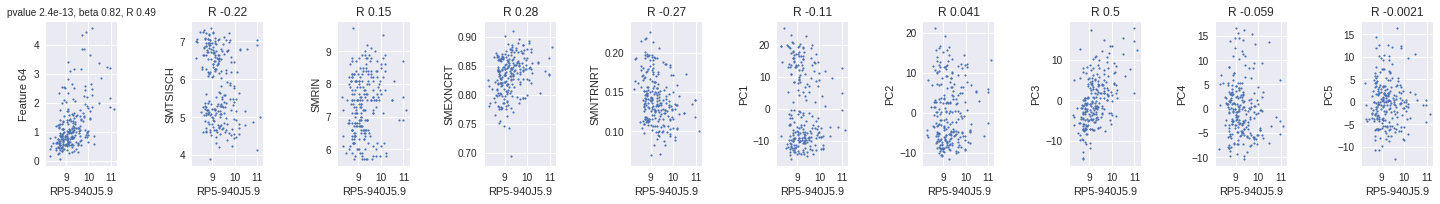

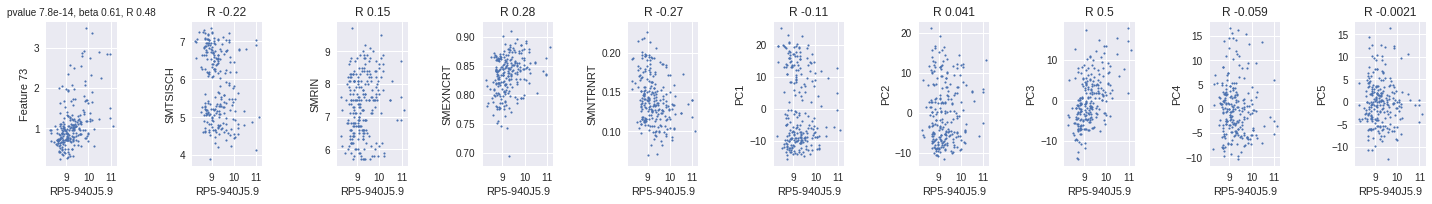

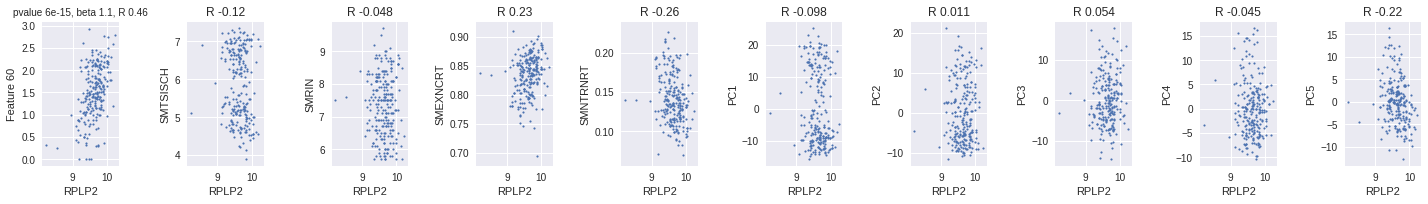

In [36]:
for t in range(200):
    for y in range(100):
        pvalue = results['{}-{}'.format(t,y)].p[-1]
        beta = results['{}-{}'.format(t,y)].coef_[-1]
        if pvalue < 1e-10 and beta > 0.6:
            try:
                print (pvalue, beta)
                display_scatter(t,y)
            except ValueError:
                continue

## Brainstorming meeting June 1st

During the brainstorming meeting, I started with the derivation of Linear Mixed Models, with the formulation:

$$Y = X\beta + Zu + \epsilon$$

$X$ is the matrix of $n$ datapoints and $p$ predictors, $Z$ is the design matrix relating data points to $g$ different groups. $u \sim N(0,D)$ and $\epsilon \sim N(0,R)$. This is equivalent to the model:

$$ Y \sim N(X\beta, ZDZ^T + R) $$

Since $Cov(Zu)$ = $Z \times Cov(u) \times Z^T$ = $ZDZ^T$



Usually, when you deal with groups within your dataset, you only know how these groups relate to one another. I.e., if $Z$ describes groupwise parameters, then $ZZ^T$ describes the similarity of each data point with respect to those parameters. Suppose we have a kinship matrix, $K$, which is constructed using genotype information. We would substitute this for $ZZ^T$ directly. If we actually had specific values for each of these groups, then we would input these values as our $Z$ matrix.

What I didn't understand in this model is how a covariate structure can have a seemingly fixed effect. The resolution, was that the covariate structure cannot have a fixed effect. Very often, all that is known about a dataset is that they form groups, and that these groups will behave similarly. This similarity is capture in a kinship matrix, $ZZ^T$. If features about the groups are known, then they can be inputted in the matrix $Z$, but in this form they do not contribute a fixed effect towards the phenotype. To allow for such a fixed effect, they must be inputted as a potential predictor in the matrix $X$. This way, this way a suitable $\beta$ can be learned to understand how much the membership of that particular group contributes to the phenotype as a fixed effect.

In [39]:
full_pca = PCA(n_components=10)

In [40]:
full_expression_pcs = full_pca.fit_transform(expression)

In [41]:
full_expression_pcs.shape

(274, 10)

In [44]:
full_expression_pcs[technical_idx,:].shape

(231, 10)

In [4]:
from sklearn.decomposition import PCA
from limix.plot import qqplot
from limix.qtl import qtl_test_lmm

lambdas = []
for k in range(1,20):
    feature = 1
    print (k)
    pca = PCA(n_components=k)
    pca_transform = pca.fit_transform(expression)
    pca_transform.shape
    test_cov = np.ones(shape=(274,k + 1))
    
    test_cov[:,1:] = pca_transform

    single_feature = filt_features[:,feature].copy()
    res = qtl_test_lmm(single_feature, filt_expression.astype(float), covs=test_cov)
    pvalues = res.getPv()

    lim_pvalues = res.getPv().flatten()
    lamb = estimate_lambda(lim_pvalues)
    lambdas.append(lamb)

1


NameError: name 'expression' is not defined

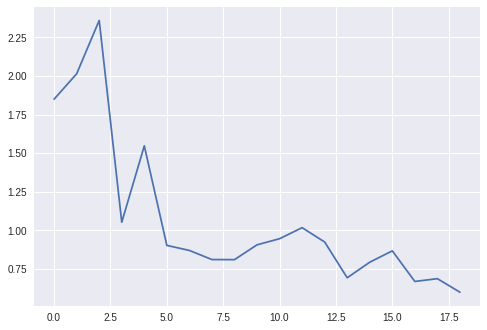

In [47]:
plt.plot(lambdas)

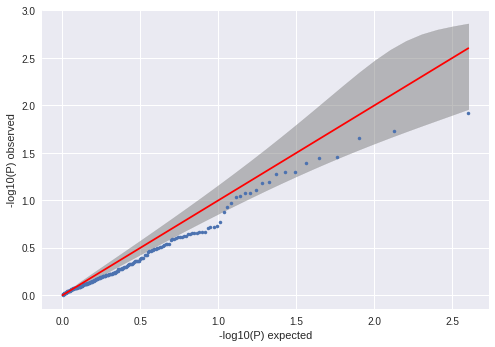

In [53]:
qqplot(pvalues.flatten())

In [56]:
lr = LinearRegression()
X = np.ones(shape=(filt_raw_technical_covariates.shape[0],filt_raw_technical_covariates.shape[1] + 2))
X[:,1:5] = filt_raw_technical_covariates
X[:,-1] = filt_tech_expression[:,t]
lr.fit(X, filt_tech_features[:,y])
res = lr.fit(X, filt_tech_features[:,y])

In [ ]:
eps 

In [62]:
X = np.ones(shape=(filt_raw_technical_covariates.shape[0],filt_raw_technical_covariates.shape[1] + pca_filt_tech_expression.shape[1] + 1))
X[:,1:5] = filt_raw_technical_covariates
X[:,5:10] = pca_filt_tech_expression
# X[:,-1] = filt_tech_expression[:,t]
lr = LinearRegression()
res = lr.fit(X, filt_tech_features[:,y])
eps = -(res.predict(X) - filt_tech_features[:,y])

In [67]:
eps.shape

(231,)

In [70]:
filt_tech_expression[:,t].shape

(231,)

In [76]:
eps.reshape(231,1).shape

(231, 1)

In [78]:
filt_tech_expression[:,t].shape

(231,)

In [101]:
R2s = [pearsonr(eps,filt_tech_expression[:,i])[0] for i in range(200)]
pvalues2 = [pearsonr(eps,filt_tech_expression[:,i])[1] for i in range(200)]

In [111]:
eps.shape

(231,)

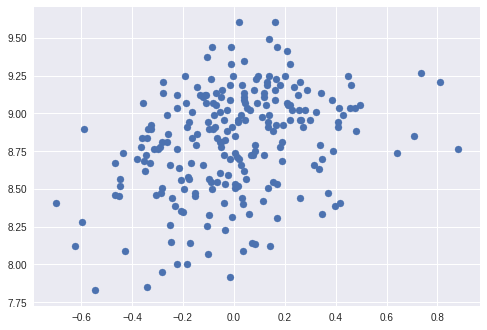

In [110]:
plt.scatter(eps,filt_tech_expression[:,134])

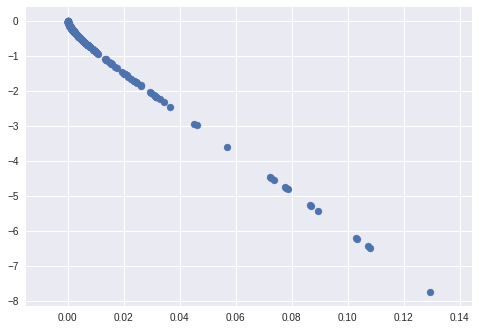

In [108]:
plt.scatter(np.array(R2s)**2,np.log10(pvalues2))

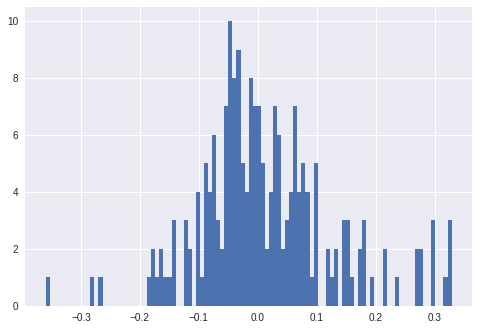

In [100]:
plt.hist(R2s,bins=100)
plt.show()

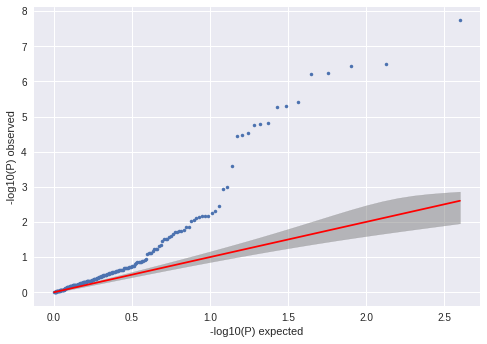

In [103]:
qqplot(np.array(pvalues2))

In [74]:
lr2 = LinearRegression()
lr2.fit(eps.reshape(231,1),filt_tech_expression[:,t])


RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class '__main__.LinearRegression'> with constructor (self, *args, **kwargs) doesn't  follow this convention.

In [2]:
from limix.qtl import qtl_test_lmm

In [3]:
qtl_test_lmm?

In [ ]:
lim